In [1]:
import os
import glob
import pandas as pd
import plotly as py
import cufflinks as cf
%matplotlib inline

In [2]:
path_to_csv = "/home/SharedFolder/trained_models/night-drive/weather_classifier/without_cloudy/train_A_over_ganaug_050_augonlyasbase"
plot_title = "train_A_over_ganaug_050_augonlyasbase"

In [3]:
csv_files = glob.glob(path_to_csv + "/*.csv")

### Combine CSVs into one DataFrame ###

In [4]:
df = pd.DataFrame()
for csv_file in csv_files:
    df = pd.concat([df, pd.read_csv(csv_file)], axis = 0)
df = df.reset_index(drop = True)

### Some preprocessing ###

In [5]:
df = df.drop(columns = ["weights"])
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,accuracy_balanced,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,1,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.790331,0.779070,0.703915,0.779070,0.759515,0.913594,0.911338,0.860348,0.798078,0.593020
1,2,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.848091,0.840532,0.773941,0.840532,0.814919,0.955264,0.952633,0.921691,0.874505,0.693866
2,3,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.871829,0.865449,0.806966,0.865449,0.848419,0.967997,0.964892,0.942431,0.900695,0.741719
3,4,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.890873,0.887043,0.839936,0.887043,0.875925,0.974170,0.970103,0.953339,0.914191,0.778384
4,5,/home/SharedFolder/CurrentDatasets/bdd100k_sor...,0.885046,0.880399,0.835454,0.880399,0.878025,0.974395,0.972965,0.954178,0.921092,0.769992


In [6]:
df.data = df.data.apply(lambda x: x.split(os.sep)[-1].split(".json")[0].split("bdd100k_sorted_")[-1])
df = df.sort_values(by = ["data", "epoch"])
df = df.reset_index(drop = True)
df.head()

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,accuracy_balanced,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,1,test,0.416610,0.357603,0.362211,0.357603,0.507598,0.558730,0.758074,0.418042,0.556142,0.217372
1,2,test,0.617604,0.548325,0.515300,0.548325,0.635635,0.775693,0.860508,0.653937,0.708613,0.354225
2,3,test,0.773570,0.740335,0.637989,0.740335,0.716836,0.897251,0.894623,0.825988,0.769045,0.483436
3,4,test,0.813300,0.795103,0.678030,0.795103,0.735718,0.926422,0.905948,0.873937,0.792658,0.536706
4,5,test,0.811756,0.793814,0.676484,0.793814,0.736812,0.929515,0.910921,0.878833,0.803043,0.535187


### Load training log file ###

In [7]:
train_log_file = glob.glob(path_to_csv + "/*.txt")
assert(len(train_log_file) == 1)

In [8]:
df_loss = pd.read_csv(train_log_file[0], sep = " ", header = None, skiprows = [0, 1])
df_loss.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Epoch,"1/40,",Batch,10/151:,Train,Loss,=,1.204,Valid,Loss,=,1.150,ETA,=,3.06h
1,Epoch,"1/40,",Batch,20/151:,Train,Loss,=,1.136,Valid,Loss,=,1.107,ETA,=,2.79h
2,Epoch,"1/40,",Batch,30/151:,Train,Loss,=,1.084,Valid,Loss,=,1.081,ETA,=,2.35h
3,Epoch,"1/40,",Batch,40/151:,Train,Loss,=,1.027,Valid,Loss,=,1.035,ETA,=,2.30h
4,Epoch,"1/40,",Batch,50/151:,Train,Loss,=,0.997,Valid,Loss,=,0.974,ETA,=,2.27h


In [9]:
df_loss = df_loss.iloc[:, [1, 3, 7, 11]].rename(columns = {1: "epoch", 3: "batch", 7: "train_loss", 11: "train_dev_loss"})
df_loss.epoch = df_loss.epoch.apply(lambda x: int(x.split("/")[0]))
df_loss.batch = df_loss.batch.apply(lambda x: int(x.split("/")[0]))
df_loss["global_batch"] = (df_loss.epoch - 1) * df_loss.batch.max() + df_loss.batch
df_loss = df_loss.sort_values(by = ["epoch", "batch"]).set_index("global_batch", drop = True)
df_loss.head()

,epoch,batch,train_loss,train_dev_loss
global_batch,,,,
10,1,10,1.204,1.150
20,1,20,1.136,1.107
30,1,30,1.084,1.081
40,1,40,1.027,1.035
50,1,50,0.997,0.974


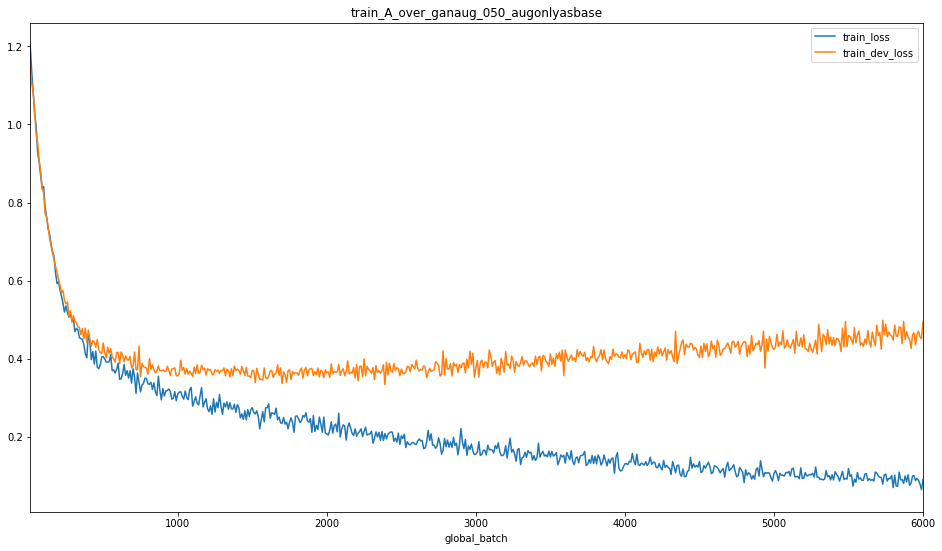

In [10]:
df_loss.plot(y = ["train_loss", "train_dev_loss"], title = plot_title, figsize = (16, 9))

### Combine loss, scores  and plot ###

In [11]:
df_combined = df_loss.groupby(by = ["epoch"]).median()
df_combined = df_combined.drop(columns = ["batch"])
df_combined.head()

,train_loss,train_dev_loss
epoch,,
1,0.869,0.881
2,0.542,0.568
3,0.445,0.461
4,0.388,0.415
5,0.354,0.396


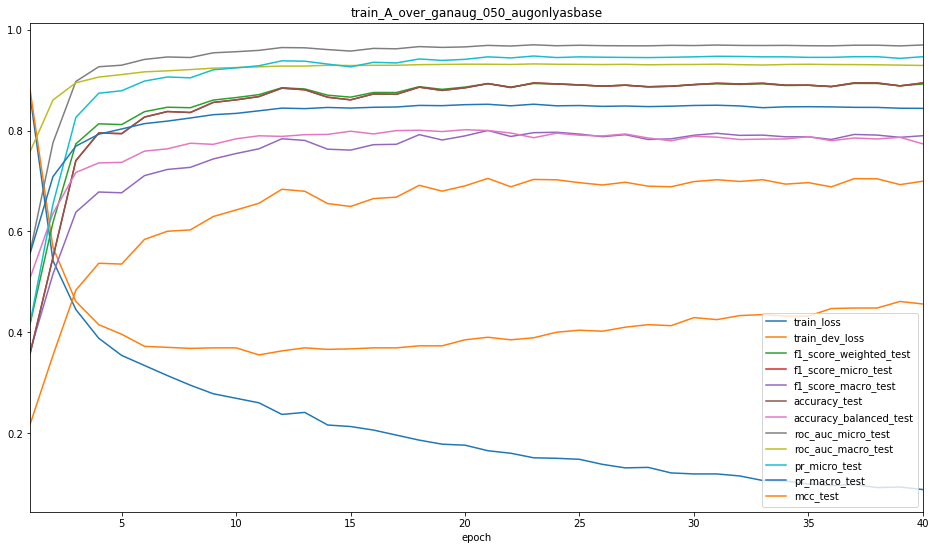

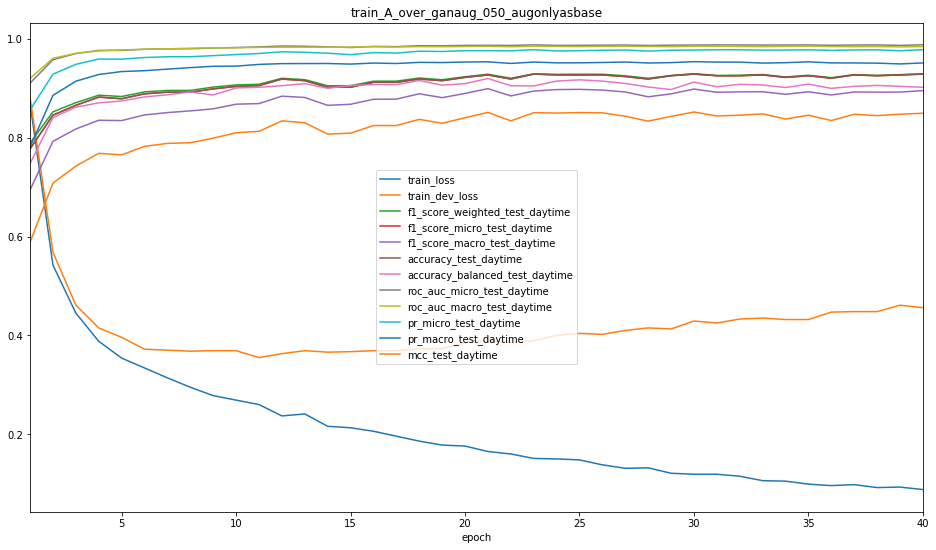

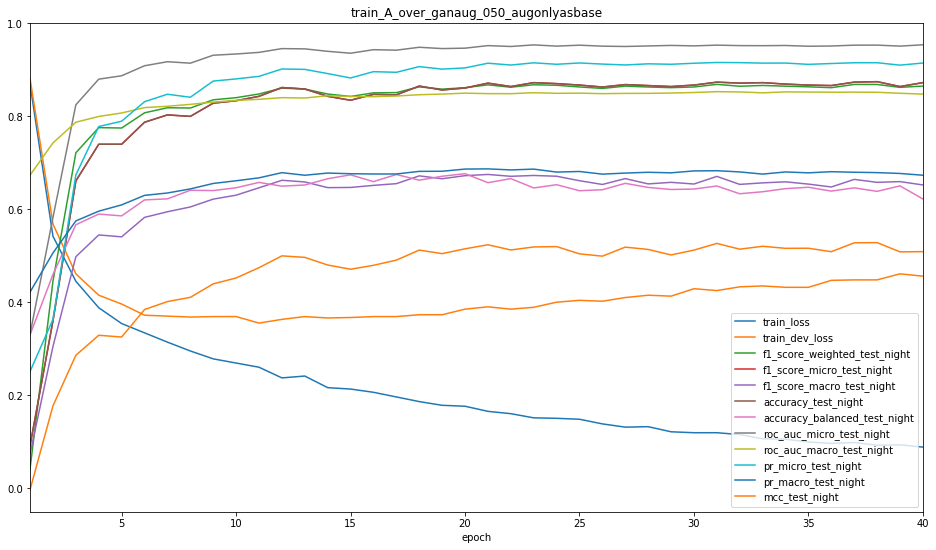

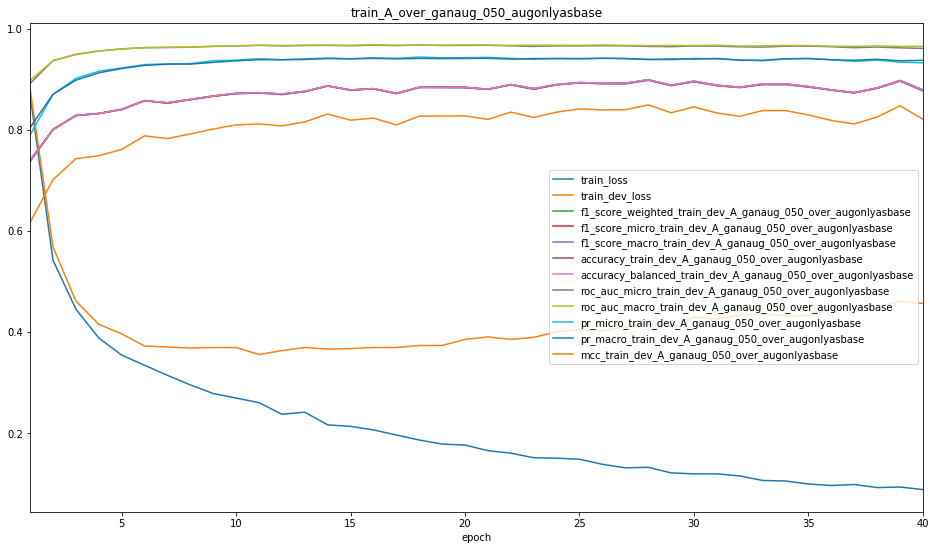

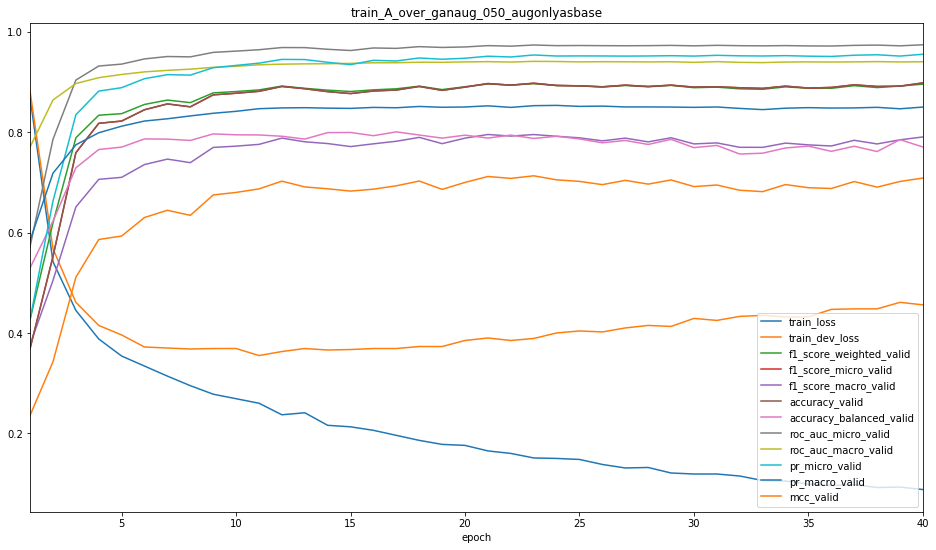

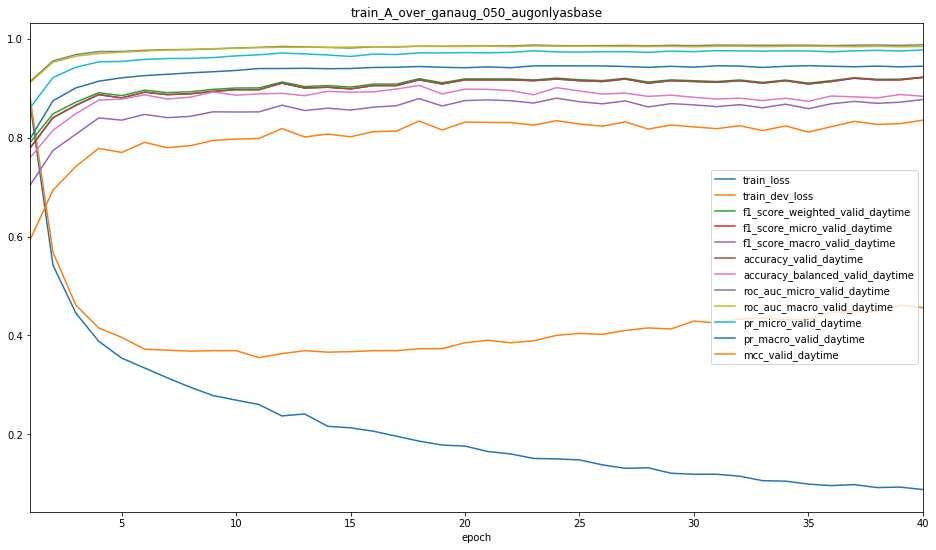

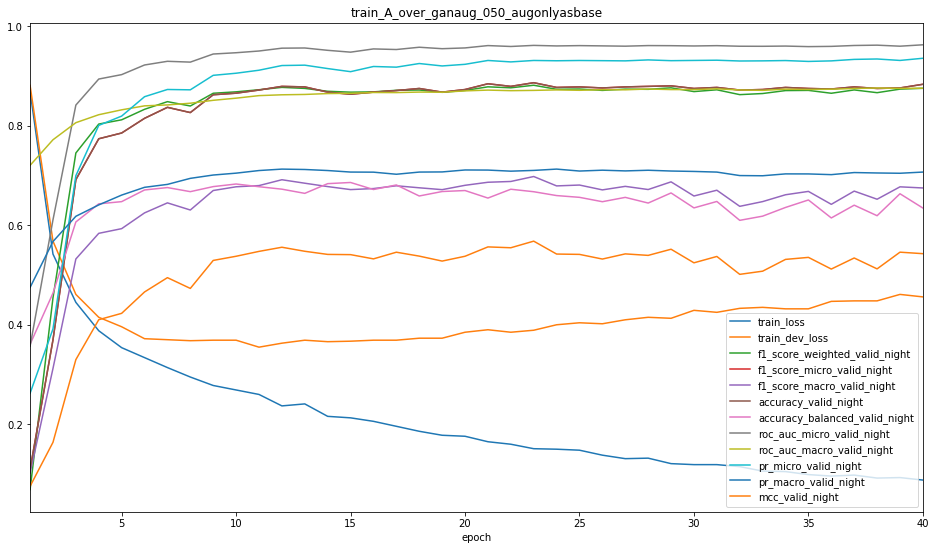

In [12]:
for data in df.data.unique():
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    df_combined_data.plot(title = plot_title, figsize = (16, 9))

### Interactive Plotly Plots ##

In [13]:
cf.go_offline(connected = True)
config = {
    "modeBarButtonsToRemove": ["sendDataToCloud"],
    "displaylogo": False
}

for data in df.data.unique():
    layout = {
        "title": "<b>" + plot_title + ' - ' + data + "<b>",
        "xaxis": {
            "title": "epoch",
            "showgrid": True,
            "showline": True,
            "linewidth": 2,
            "gridcolor": '#bdbdbd',
            "gridwidth": 2,
            "tickmode": 'linear',
            "ticks": 'outside',
            "tickwidth": 2,
            "tick0": 0,
            "dtick": 1,
        },
        "yaxis": {
            "title": "metric",
            "range": [0, 1.01],
            "showgrid": True,
            "showline": True,
            "linewidth": 2,
            "gridcolor": '#bdbdbd',
            "gridwidth": 2,
            "tickmode": 'linear',
            "ticks": 'outside',
            "tickwidth": 2,
             "tick0": 0,
            "dtick": 0.1,
        },  
        "width": 960,
        "height": 540
    }
    df_data = df.loc[df.data == data]
    df_data = df_data.drop(columns = ["data"])
    df_data = df_data.set_index("epoch", drop = True)
    df_data = df_data.add_suffix("_" + data)
    df_combined_data = df_combined.merge(df_data, on = "epoch")
    fig = df_combined_data.iplot(layout = layout, asFigure = True)
    py.offline.iplot(fig, show_link = False, config = config)